# Analysis of the autism data

In [1]:
run init.ipynb

Done.


# Description

In [20]:
def select(data,feature,value,unique=False):
    """Example : select(data,'ASD+',1,unique=True)
                 select(data,'sex','Male')
    """
    if unique:
        data_unique=data.drop_duplicates(subset = "id",keep='first')
        selected_data = data_unique[data_unique[feature]==value]
    else:
        selected_data = data[data[feature]==value]
    return(selected_data)

Predicting diagnosis based on 40 features

**********************************
 statistics:

**********************************
1220 subjects 
697  male
523  female
0  unknown sex beacause of missing clinical data 


**********************************
192 subjects in the ASD group
136 number of male
56 number of female 
 

**********************************
950 subjects in the TD group
502 number of male
448 number of female 


**********************************
29 subjects in the DL/DD group
21 number of male
8 number of female 


**********************************
49 subjects in the ADHD group
38 number of male
38 number of female 



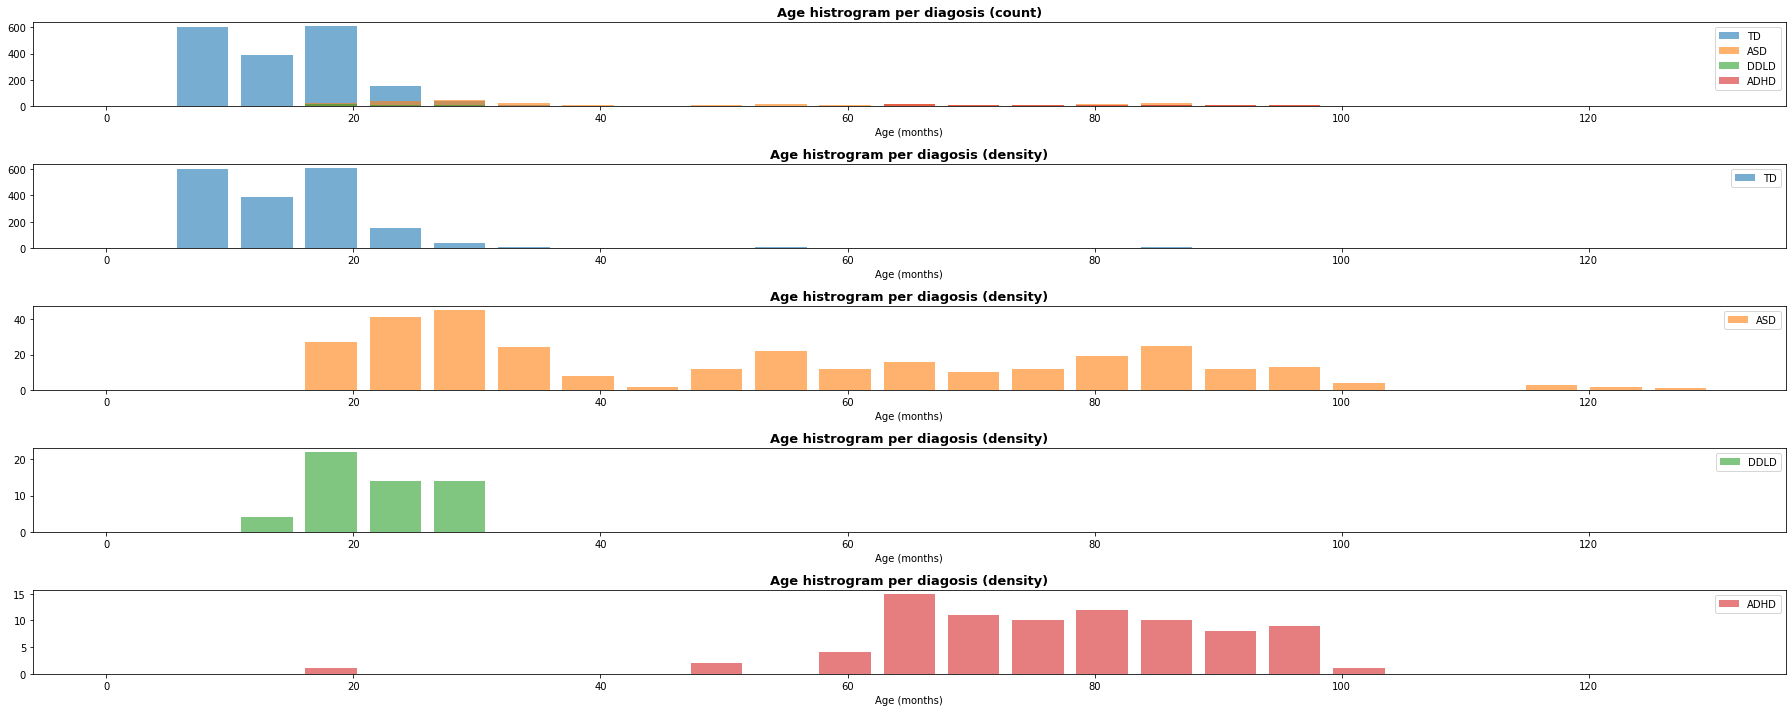

In [54]:
df = pd.read_csv("/home01/sam/df_all.csv")

data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               proportion_train=1)

DIAG_DICT = {'TD':0., 
            'ASD':1., 
            'DDLD':2., 
            'ADHD':3.}
DIAG_DICT_REVERSE = {v: k for k, v in DIAG_DICT.items()}

colors = {'TD':'#1f77b4',
          'ASD': '#ff7f0e',
          'DDLD':'#2ca02c',
          'ADHD':'#d62728',
          'comorbid':'#9467bd'}
           
    
fig, axes = plt.subplots(5, 1, figsize=(25, 10)); axes=axes.flatten()

for i, d in df.groupby('diagnosis'):
    axes[0].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
axes[0].legend(); axes[0].set_title("Age histrogram per diagosis (count)", weight='bold', fontsize=13); axes[0].set_xlabel("Age (months)")

for i, d in df.groupby('diagnosis'):
    axes[int(i+1)].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
    axes[int(i+1)].legend(); axes[int(i+1)].set_title("Age histrogram per diagosis (density)", weight='bold', fontsize=13);axes[int(i+1)].set_xlabel("Age (months)")
plt.tight_layout()


"""
    Print population statistics at the beginning of the notebook.
"""
print('\n**********************************')
print(' statistics:')
print('\n**********************************')
data = df
# Masks
data_unique=data.drop_duplicates(subset = "id",keep='first')
data_unique_asd = select(data,'diagnosis',1,True)
data_unique_nasd = select(data,'diagnosis',0,True)
data_male = select(data,'sex',0)
data_female = select(data,'sex',1)
data_asd = select(data,'diagnosis',1)
data_nasd = select(data,'diagnosis',0)


#Count the number of subjects
subjects_id = np.unique(data['id'])
number_of_subjects = len(subjects_id)

subject_male = np.sum(data_unique['sex']==0)
subject_female = np.sum(data_unique['sex']==1)
subject_unknown = np.sum(pd.isna(data_unique['sex']))

print('{} subjects '.format(number_of_subjects))
print('{}  male'.format(subject_male))
print('{}  female'.format(subject_female)) 
print('{}  unknown sex beacause of missing clinical data \n'.format(subject_unknown)) 

# mchat_total_1_positive=data_unique.loc[data_unique['clinical_mchat_total_score']>=3]
# mchat_final_1_positive = mchat_total_1_positive.loc[mchat_total_1_positive['clinical_final_mchat_score']>=2]    
# mchat_total_2_positive=data_unique.loc[data_unique['clinical_mchat_total_score2']>=3]
# mchat_final_2_positive = mchat_total_1_positive.loc[mchat_total_1_positive['clinical_final_mchat_score2']>=2]    

# print('\n**********************************')
# print('{} subjects are "mchat positive" (First Adminisstration) '.format(len(mchat_final_1_positive)))
# print('{} subjects are "mchat positive" (Second Adminisstration) '.format(len(mchat_final_2_positive)))


nasd_subjects_id = data_unique_nasd[['id','sex']]
nasd_subject_male = np.sum(data_unique_nasd['sex']==0)
nasd_subject_female = np.sum(data_unique_nasd['sex']==1)

asd_subjects_id = data_unique_asd[['id','sex']]
asd_subject_male = np.sum(data_unique_asd['sex']==0)
asd_subject_female = np.sum(data_unique_asd['sex']==1)

dd_subjects_id = select(data_unique,'diagnosis', 2)[['id','sex']]
dd_subject_male = np.sum(dd_subjects_id['sex']==0)
dd_subject_female = np.sum(dd_subjects_id['sex']==1)

adhd_subjects_id = select(data_unique,'diagnosis', 3)[['id','sex']]
adhd_subject_male = np.sum(adhd_subjects_id['sex']==0)
adhd_subject_female = np.sum(adhd_subjects_id['sex']==1)

print('\n**********************************')
print('{} subjects in the ASD group'.format(len(asd_subjects_id)))
print('{} number of male'.format(asd_subject_male))
print('{} number of female \n '.format(asd_subject_female)) 


print('\n**********************************')
print('{} subjects in the TD group'.format(len(nasd_subjects_id)))
print('{} number of male'.format(nasd_subject_male))
print('{} number of female \n'.format(nasd_subject_female)) 



print('\n**********************************')
print('{} subjects in the DL/DD group'.format(len(dd_subjects_id)))
print('{} number of male'.format(dd_subject_male))
print('{} number of female \n'.format(dd_subject_female)) 

print('\n**********************************')
print('{} subjects in the ADHD group'.format(len(adhd_subjects_id)))
print('{} number of male'.format(adhd_subject_male))
print('{} number of female \n'.format(adhd_subject_male)) 

In [81]:
import missingno as msno

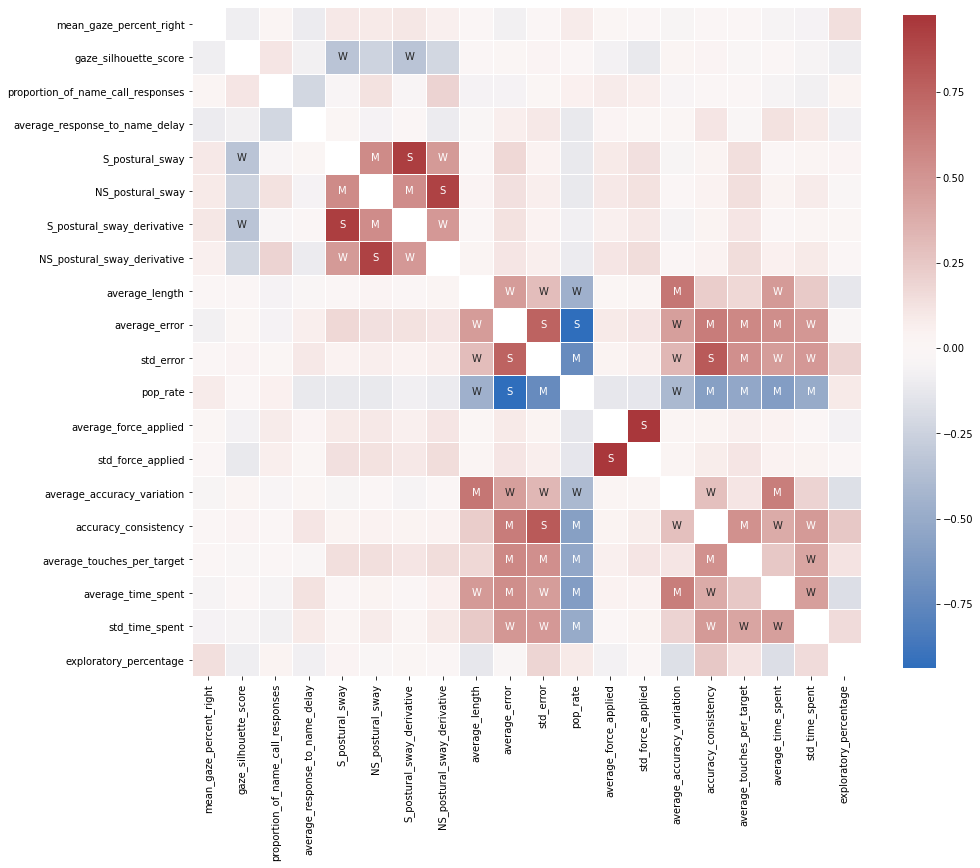

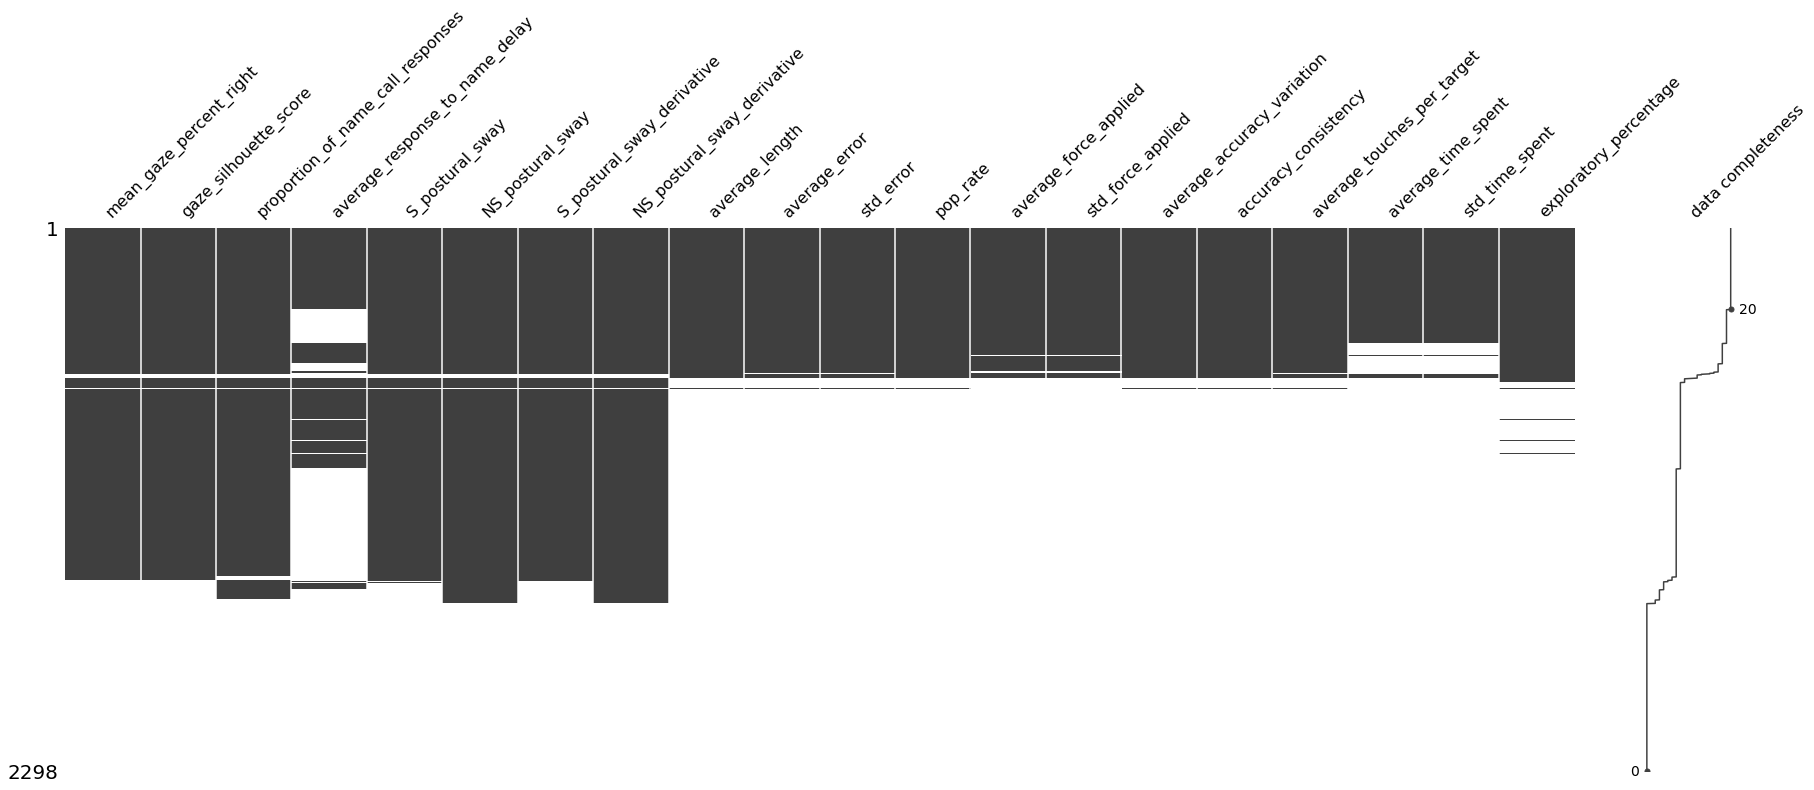

In [89]:
df_X = df[data.features_name[:int(len(data.features_name)//2)]]
# Computes feature correlation
df_corr = df_X.corr(method="pearson")

labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});


msno.matrix(df_X, labels=True, sort="descending", figsize=(30, 10));

In [102]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(df_corr_stacked)

pop_rate                     average_error           -0.936662
                             std_error               -0.723631
average_time_spent           pop_rate                -0.593849
accuracy_consistency         pop_rate                -0.582379
average_touches_per_target   pop_rate                -0.532550
                                                        ...   
std_error                    average_error            0.756120
accuracy_consistency         std_error                0.801857
NS_postural_sway_derivative  NS_postural_sway         0.912165
S_postural_sway_derivative   S_postural_sway          0.935392
std_force_applied            average_force_applied    0.973714
Length: 190, dtype: float64

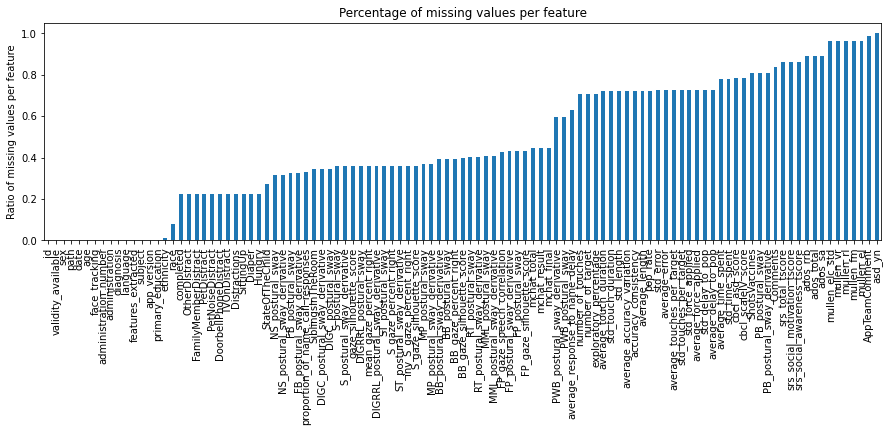

In [85]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

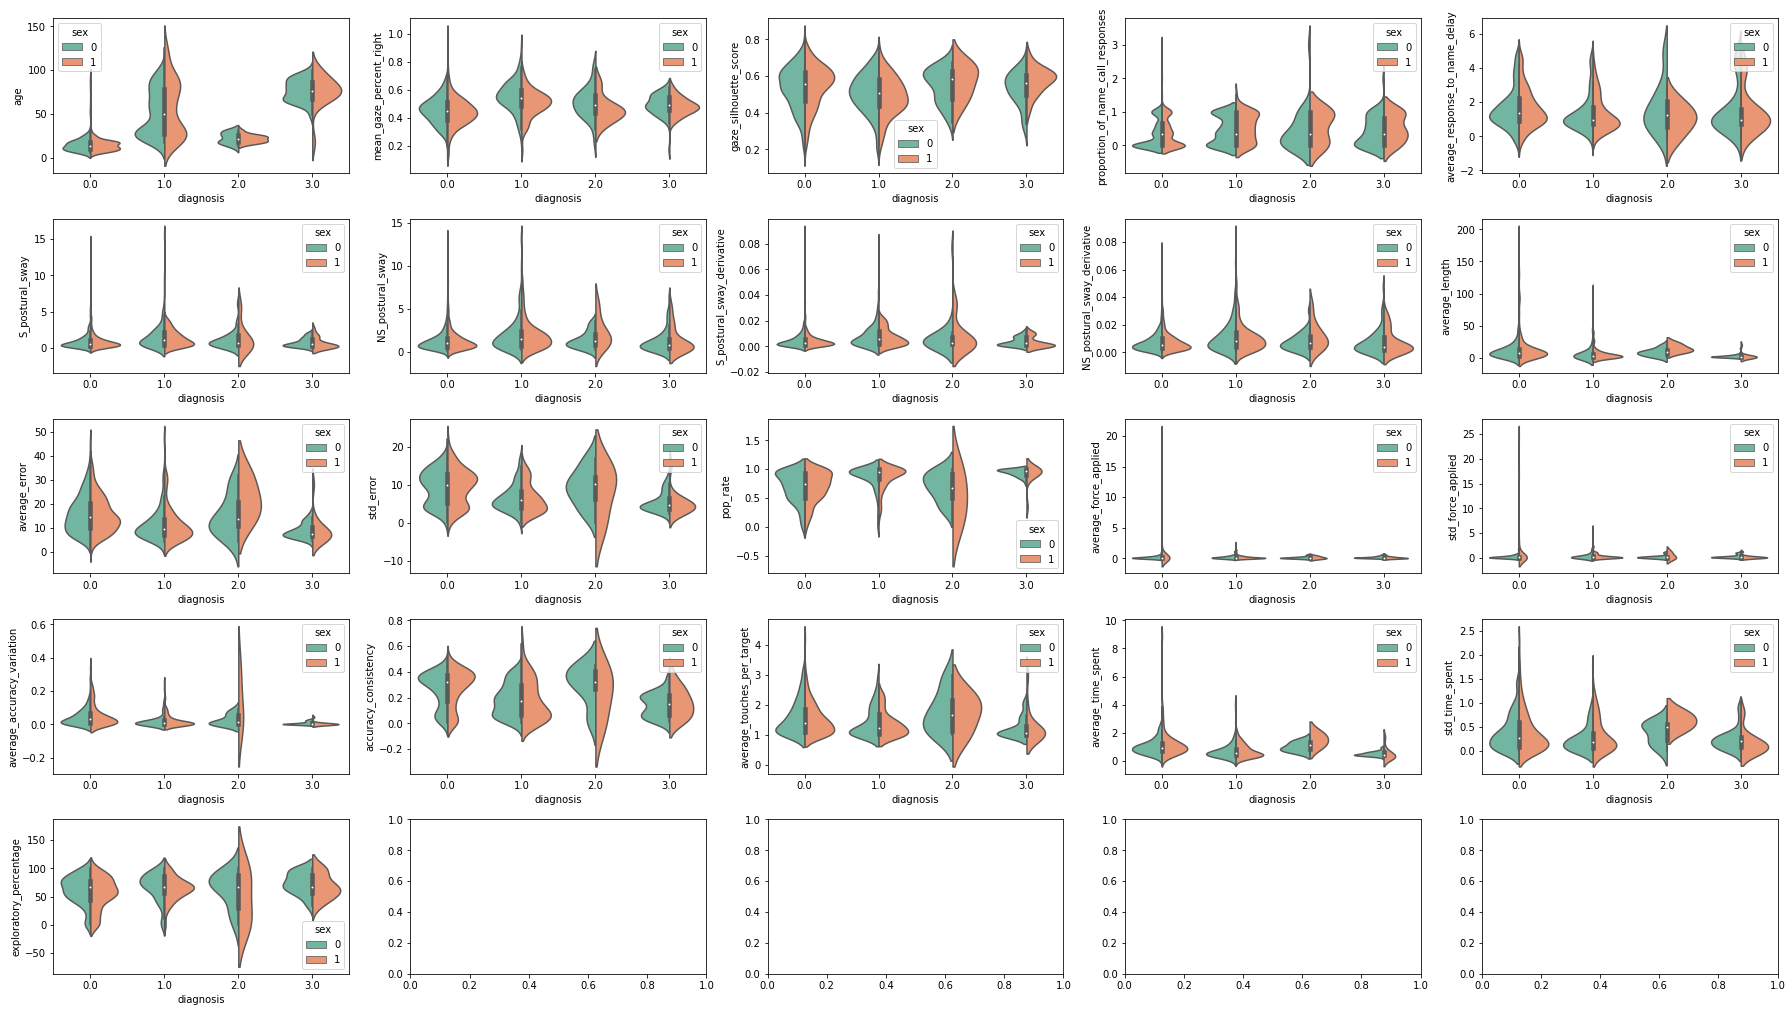

In [129]:
selected_features = ['age'] + data.features_name[:int(len(data.features_name)//2)]

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=5, nrows=len(selected_features)//5 +1, figsize=(25, 14))
# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df, y=col, x='diagnosis', hue='sex', palette="Set2",
                   split=True, ax=ax)
plt.tight_layout()

# developpe dataset task

In [156]:
n_todo = 0
for scale_data in [True, False]:
    for missing_data_handling in ['encoding', 'without', 'imputation']:
        for imputation_method in ['without','mice', 'knn', 'mean']:
            for sampling_method in ['without', 'vanilla', 'smote']:
                for use_missing_indicator_variables in [True, False]:
                    for num_cv in [8, 16]:
                        for scenario in [1, 2]:
                            for approach in ["LogisticRegression", "DecisionTree", "xgboost", "nam", "ebm"]:

                                
                                if ((approach in ["LogisticRegression", "DecisionTree", 'nam', 'ebm'] and missing_data_handling=='without') or
                                    (missing_data_handling != 'imputing' and imputation_method!='without') or
                                    (missing_data_handling == 'imputing' and imputation_method=='without')):
                                        continue
                                else:
                                    n_todo+=1
                                    
                                print("{} - {} - missing_data_handling {} imputation_method: sampling_method: {} scale_data: {} use_missing_indicator_variables: {} scenario: {} ".format(n_todo, 
                                                                                                                                                                                            approach,
                                                                                                                                                                                            missing_data_handling,
                                                                                                                                                                                            imputation_method, 
                                                                                                                                                                                            sampling_method,
                                                                                                                                                                                            scale_data,
                                                                                                                                                                                            use_missing_indicator_variables,
                                                                                                                                                                                            scenario))

                                
                                df = pd.read_csv("/home01/sam/df_all.csv")
                                data = Dataset(df=df, 
                                               missing_data_handling=missing_data_handling,
                                               imputation_method=imputation_method,
                                               sampling_method=sampling_method,
                                               scale_data=scale_data, 
                                               use_missing_indicator_variables=use_missing_indicator_variables,
                                               verbosity=0, 
                                               proportion_train=1)
                                
                                if scenario==1:
                                    data.filter(administration={'order': 'first', 
                                                                 'completed': True}, 
                                                clinical={'diagnosis': [0, 1]}, 
                                                demographics={'age':[10, 60]}, 
                                                matching={'age':[0, 1]}, verbose=False)


                                elif scenario==2:
                                    data.filter(administration={'order': 'first', 
                                                                 'completed': True}, 
                                                clinical={'diagnosis': [0, 1]}, 
                                                demographics={'age':[10, 30]}, 
                                                matching={'age':[0, 1]}, verbose=False)
                                    
                                exp = Experiments(data.dataset_name,
                                                  dataset=data, 
                                                  approach=approach, 
                                                  previous_experiment=None,        
                                                  debug=True, 
                                                  verbosity=0, 
                                                  save_experiment=False)
                                exp.features_name =['mean_gaze_percent_right', 'average_length']
                                exp.fit_predict(num_cv=num_cv)

1 - LogisticRegression - missing_data_handling encoding imputation_method: sampling_method: without scale_data: without use_missing_indicator_variables: True scenario: True 
2 - DecisionTree - missing_data_handling encoding imputation_method: sampling_method: without scale_data: without use_missing_indicator_variables: True scenario: True 
3 - xgboost - missing_data_handling encoding imputation_method: sampling_method: without scale_data: without use_missing_indicator_variables: True scenario: True 
4 - nam - missing_data_handling encoding imputation_method: sampling_method: without scale_data: without use_missing_indicator_variables: True scenario: True 
5 - ebm - missing_data_handling encoding imputation_method: sampling_method: without scale_data: without use_missing_indicator_variables: True scenario: True 
6 - LogisticRegression - missing_data_handling encoding imputation_method: sampling_method: without scale_data: without use_missing_indicator_variables: True scenario: True 
7 -

KeyboardInterrupt: 

In [161]:
from autismDataset import Dataset

df = pd.read_csv("/home01/sam/df_all.csv")
data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='vanilla',
               proportion_train=1)

data.filter(administration={'order': 'first', 
                             'completed': True}, 
            clinical={'diagnosis': [0, 1]}, 
            demographics={'age':[10, 60]}, 
            matching={'age':[0, 1]}, verbose=False)



Predicting diagnosis based on 40 features
Splitting dataset into test and train set.
Encoding 237 (train) and 0 (test) missing values with -5.
Upampling minority class. Imbalance ratio of: 0.93 to 1.00


In [164]:
exp = Experiments(data.dataset_name,
                  dataset=data, 
                approach='nam', 
                proportion_train=PROPORTION_TRAIN, 
                resolution=RESOLUTION, 
                bandwidth=BANDWIDTH, 
                previous_experiment=None,        
                verbosity=1, 
                debug=True, 
                save_experiment=True)

Doing experiment 18!


In [ ]:
exp.fit_predict(num_cv=16)
exp.plot()

Encoding 237 (train) and 0 (test) missing values with -5.
Epoch: 1/2;	 Batch: 1/14;	 Err: 1.392
Epoch: 1/2;	 Batch: 2/14;	 Err: 1.221
Epoch: 1/2;	 Batch: 3/14;	 Err: 1.052
Epoch: 1/2;	 Batch: 4/14;	 Err: 1.190
Epoch: 1/2;	 Batch: 5/14;	 Err: 1.005
Epoch: 1/2;	 Batch: 6/14;	 Err: 1.003
Epoch: 1/2;	 Batch: 7/14;	 Err: 1.018
Epoch: 1/2;	 Batch: 8/14;	 Err: 1.242
Epoch: 1/2;	 Batch: 9/14;	 Err: 0.776
Epoch: 1/2;	 Batch: 10/14;	 Err: 0.998
Epoch: 1/2;	 Batch: 11/14;	 Err: 0.972
Epoch: 1/2;	 Batch: 12/14;	 Err: 1.245
Epoch: 1/2;	 Batch: 13/14;	 Err: 1.039
Epoch: 1/2;	 Batch: 14/14;	 Err: 0.993

	 Epoch finished in 0.36 seconds!

Epoch: 2/2;	 Batch: 1/14;	 Err: 0.998
Epoch: 2/2;	 Batch: 2/14;	 Err: 1.328
Epoch: 2/2;	 Batch: 3/14;	 Err: 1.116
Epoch: 2/2;	 Batch: 4/14;	 Err: 1.035
Epoch: 2/2;	 Batch: 5/14;	 Err: 0.863
Epoch: 2/2;	 Batch: 6/14;	 Err: 0.952
Epoch: 2/2;	 Batch: 7/14;	 Err: 1.148
Epoch: 2/2;	 Batch: 8/14;	 Err: 1.226
Epoch: 2/2;	 Batch: 9/14;	 Err: 0.976
Epoch: 2/2;	 Batch: 10/14;	

Encoding 237 (train) and 0 (test) missing values with -5.


,Accuracy,F1 score (2 PPVxTPR/(PPV+TPR)),Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.776,0.774,0.554,0.798,0.756,0.752,0.802,0.202,0.248,0.198


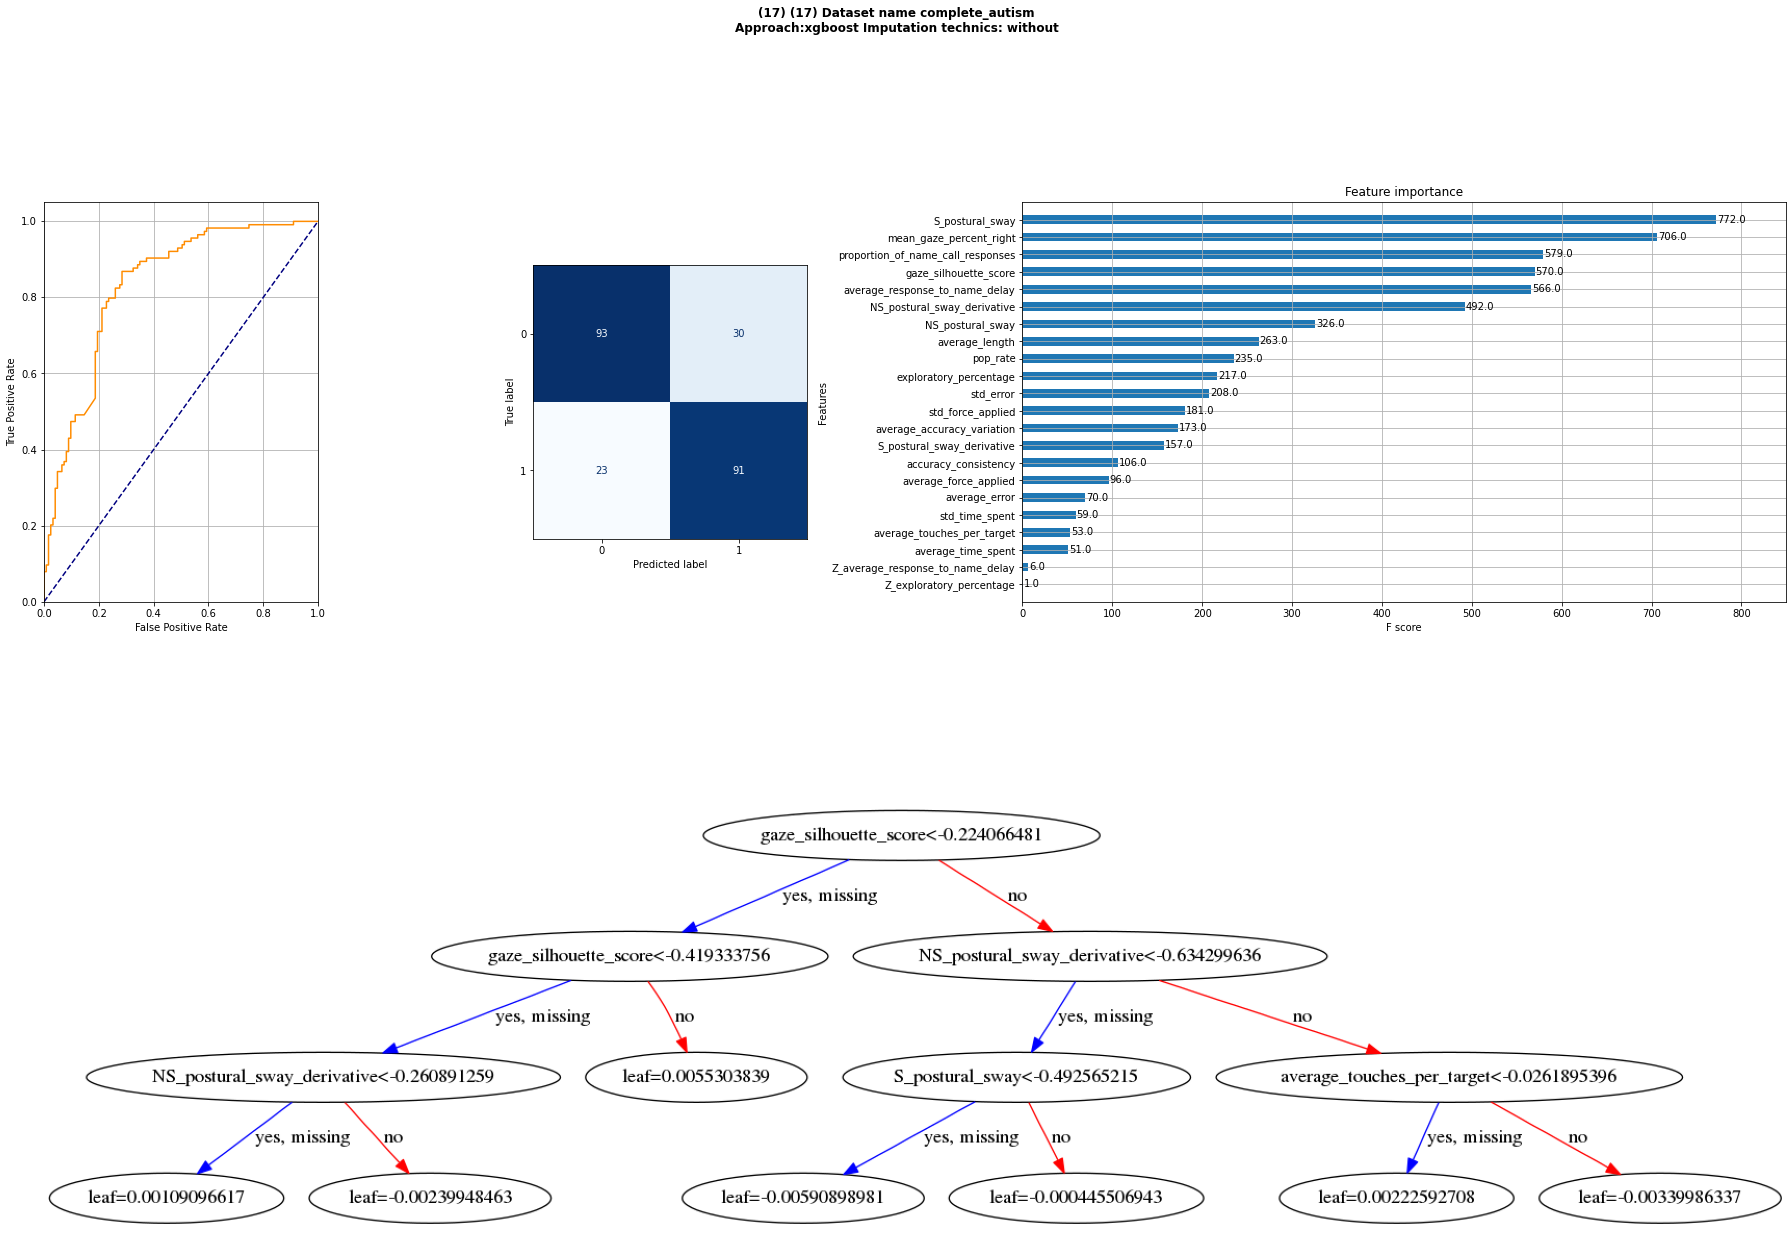

In [163]:
exp.fit_predict(num_cv=16)
exp.plot()

,Accuracy,F1 score (2 PPVxTPR/(PPV+TPR)),Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.798,0.552,0.425,0.514,0.889,0.597,0.851,0.486,0.403,0.149


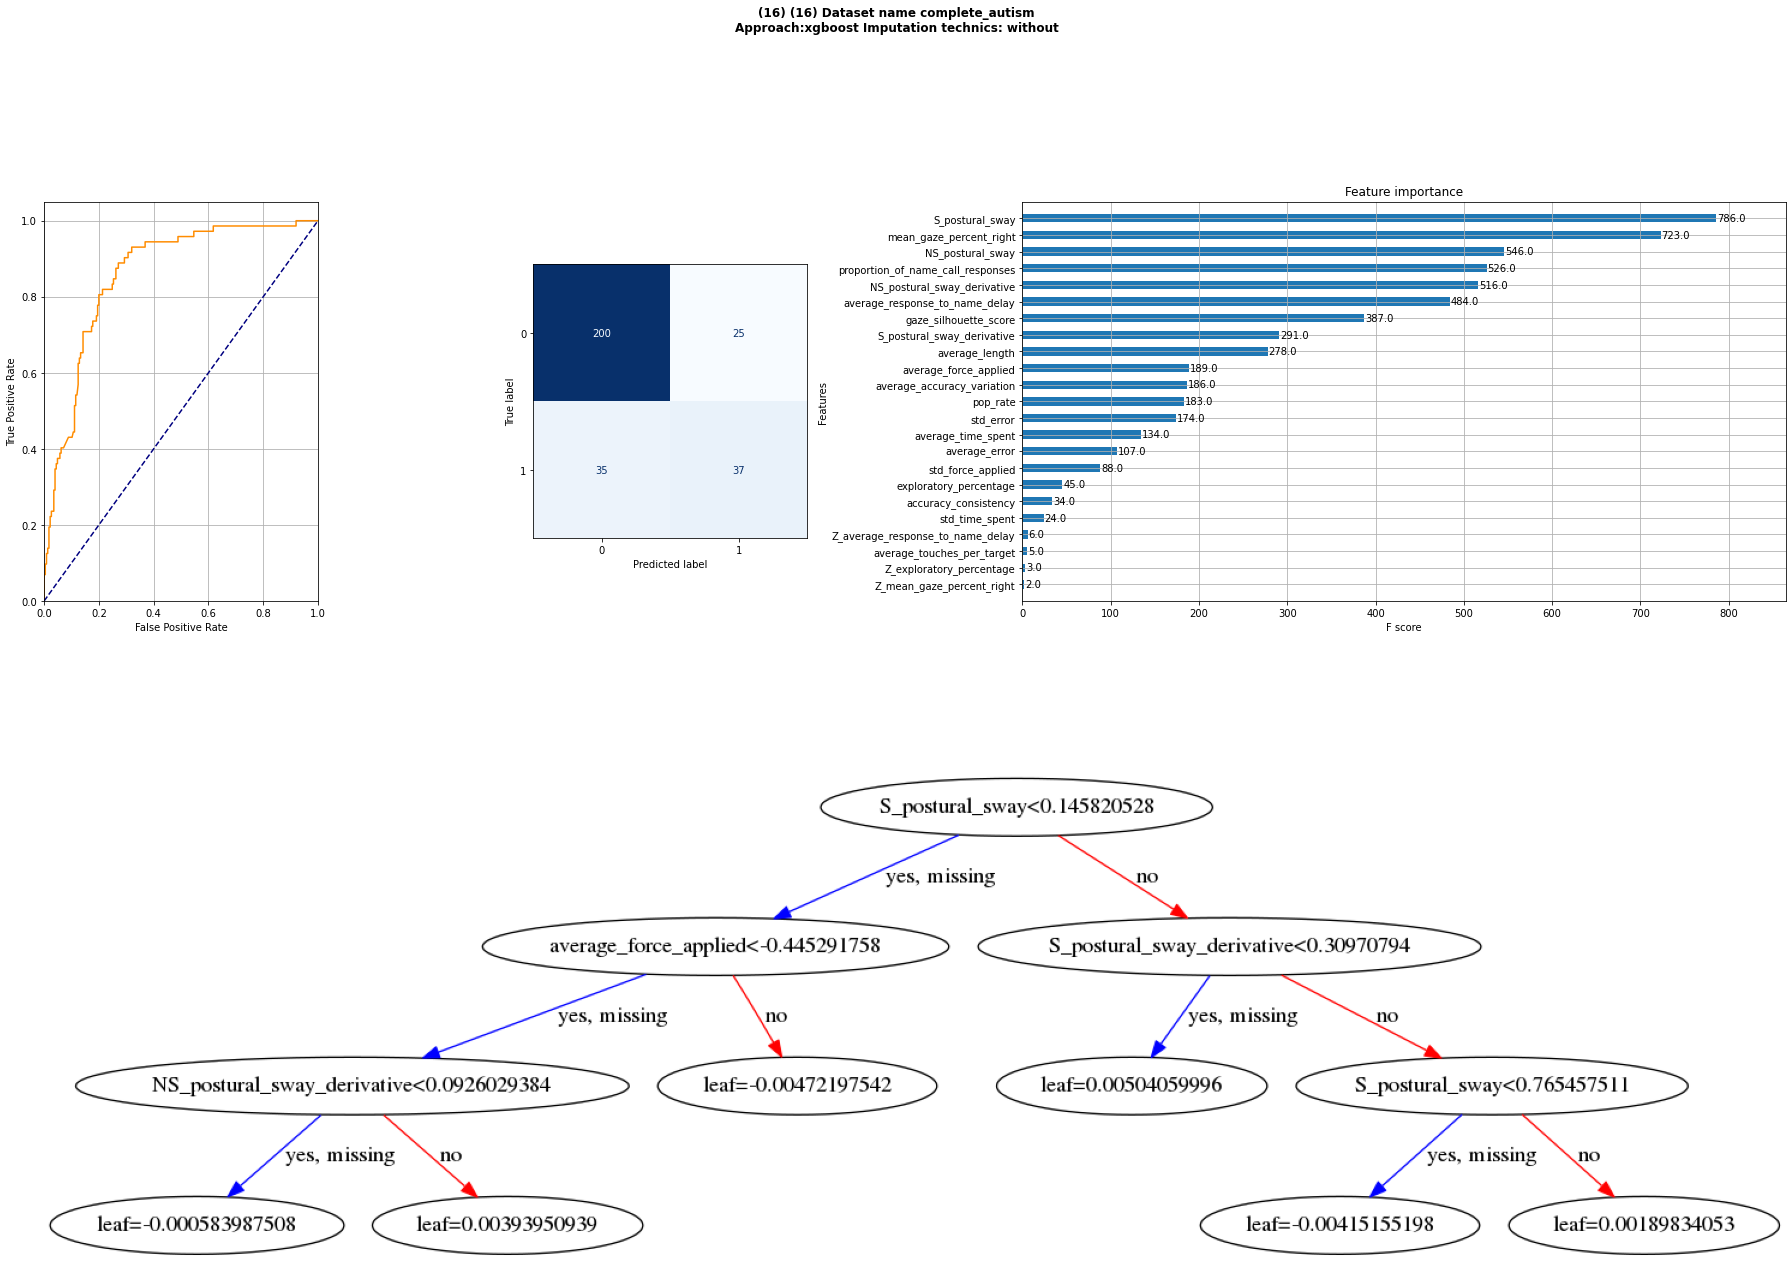

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve
precision, recall, ths_pr = precision_recall_curve(exp.predictions_df.y_true.to_numpy(), exp.predictions_df.y_pred.to_numpy())
df.dropna(subset=['age']).query("`diagnosis` == @group2")

,id,diagnosis,language,app_version,subject,administration,features_extracted,face_tracking,age,date,path,sex,ethnicity,race,primary_education,asd_yn,mullen_el,mullen_fm,mullen_rl,mullen_vr,mullen_elc_std,ados_total,ados_rrb,ados_sa,srs_total_tscore,srs_social_awareness_tscore,srs_social_motivation_tscore,cbcl_scaleIV_score,cbcl_asd_score,mchat_total,mchat_final,mchat_result,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,...,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage,completed,StateOfTheChild,SiblingsInTheRoom,ShotsVaccines,Distractions,FamilyMemberDistract,PetDistract,PetNoiseDistract,DoorbellPhoneDistract,TVOnDistract,OtherDistract,SittingUp,Hungry,Diaper,AppTeamComment,Comments,validity_available,administration_number,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,gaze_silhouette_score,inv_S_gaze_percent_right,mean_gaze_percent_right
6,300472,1.0,English,3.2.6,<Subject.S2KSubject object at 0x7f14f6050450>,<Administration.S2KAdministration object at 0x...,0,0,29.049180,2022-03-13 15:42:00,/diskD/AutismCenter/Data/SenseToKnow/Processed...,1,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete (Do not readminister),1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,301344,1.0,Spanish,3.2.6,<Subject.S2KSubject object at 0x7f153111d7d0>,<Administration.S2KAdministration object at 0x...,0,0,25.868852,2022-05-13 14:01:00,/diskD/AutismCenter/Data/SenseToKnow/Processed...,0,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,301457,1.0,English,3.2.6,<Subject.S2KSubject object at 0x7f153112e350>,<Administration.S2KAdministration object at 0x...,0,1,23.770492,2022-04-03 11:11:00,/diskD/AutismCenter/Data/SenseToKnow/Processed...,1,0.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,15.0,1.0,0.454986,0.603213,0.520875,0.661585,0.000000,0.342632,0.333333,0.166833,1.167699,0.006099,0.449787,0.001609,1.874657,0.013183,0.450682,0.001688,1.877346,0.016626,...,0.024666,2.250505,0.010816,1.537106,0.007085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete (Do not readminister),NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,1.0,1.792508,1.342372,0.010274,0.009379,0.535810,0.479125,0.467056
14,303394,1.0,English,3.2.6,<Subject.S2KSubject object at 0x7f14f7d734d0>,<Administration.S2KAdministration object at 0x...,0,1,19.311475,2022-02-03 08:26:00,/diskD/AutismCenter/Data/SenseToKnow/Processed...,0,0.0,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4.0,1.0,0.386139,0.431975,0.343396,0.444226,0.050034,0.276040,0.000000,NaN,0.969266,0.00

In [37]:
group1=0
group2=1
df = data.df

    


20.627139164294366

,Accuracy,F1 score (2 PPVxTPR/(PPV+TPR)),Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.837,0.163,0.144,0.101,0.974,0.421,0.853,0.899,0.579,0.147


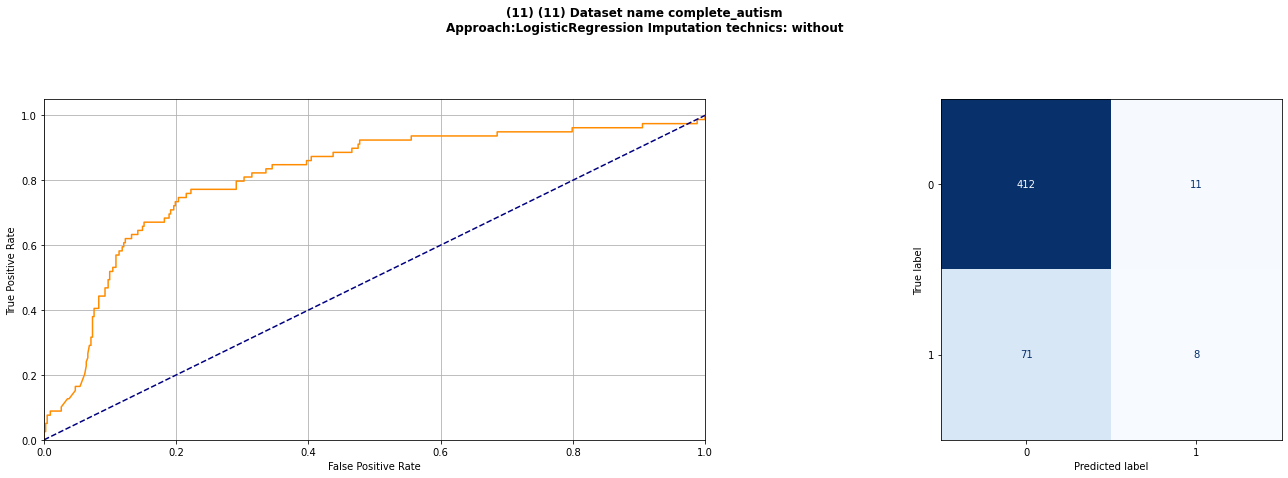

Not implemented yet.


In [43]:
exp.plot()

In [21]:
data.keys()

AttributeError: 'Dataset' object has no attribute 'keys'

# Exploit results

ADD FILTERS TO THE DF AND THEN GOOOO 

In [197]:
folder_names = ['autism_all']

if not isinstance(folder_names, list):
    folder_names = list(folder_names)


df = pd.DataFrame(columns = ['dataset_name','experiment_number', 'approach', 'missing_data_handling','imputation_method', 'features_name', 'use_missing_indicator_variables', 
                            'num_samples', 'imbalance_ratio', 'ratio_of_missing_values','ratio_missing_per_class_0', 'ratio_missing_per_class_1', 'resolution', 'bandwidth', 'estimation_time', 'auc',
                            'Accuracy', 'F1', 'MCC', 'Sensitivity', 'Specificity', 'Precision', 'PPV', 'NPV', 'FNR', 'FDR', 'FOR'])


experiments_paths = []
for folder_name in folder_names:
    experiments_paths.extend(glob(os.path.join(DATA_DIR, folder_name, "*", '*')))


for experiment_path in experiments_paths:


    exp_path = os.path.join(experiment_path, 'experiment_log.json')
    dataset_path = os.path.join(experiment_path, 'dataset_log.json')

    dist_None_path = os.path.join(experiment_path, 'distributions_None_log.json')
    dist_1_path = os.path.join(experiment_path, 'distributions_1_log.json')
    dist_0_path = os.path.join(experiment_path, 'distributions_0_log.json')

    dist_0_data, dist_0_data, dist_None_data = None, None, None

    if os.path.isfile(exp_path):

        with open(exp_path) as experiment_json:

            # Load experiment data
            experiment_data = json.load(experiment_json)
    else:
        continue

    if os.path.isfile(dataset_path):
        with open(dataset_path) as data_json:

            # Load experiment data
            dataset_data = json.load(data_json)
    else:
        continue

    if os.path.isfile(dist_None_path):

        with open(dist_None_path) as dist_json:

            # Load experiment data
            dist_None_data = json.load(dist_json)

    if os.path.isfile(dist_1_path):

        with open(dist_1_path) as dist_json:

            # Load experiment data
            dist_1_data = json.load(dist_json)

    if os.path.isfile(dist_0_path):

        with open(dist_0_path) as dist_json:

            # Load experiment data
            dist_0_data = json.load(dist_json)

    # append rows to an empty DataFrame
    df = df.append({'dataset_name' : experiment_data['dataset_name'], 
                    'experiment_number' : experiment_data['experiment_number'],  
                    'approach' : experiment_data['approach'],  
                    'missing_data_handling' : dataset_data['missing_data_handling'],  
                    'imputation_method' : dataset_data['imputation_method'],  
                    'features_name': str(dataset_data['_features_name']) if not dataset_data['use_missing_indicator_variables'] else str(dataset_data['_features_name'][:int(len(dataset_data['_features_name'])//2)]),
                    'use_missing_indicator_variables': dataset_data['use_missing_indicator_variables'], #if 'use_missing_indicator_variables' in experiment_data.keys() else None,   # TODO 
                    'num_samples' : dataset_data['num_samples'],  
                    'imbalance_ratio' : dataset_data['imbalance_ratio'],  
                    'ratio_of_missing_values' : dataset_data['ratio_of_missing_values'],  
                    'ratio_missing_per_class_0' : dataset_data['ratio_missing_per_class'][0],
                    'ratio_missing_per_class_1' : dataset_data['ratio_missing_per_class'][1],
                    'resolution' : experiment_data['resolution'],
                    'bandwidth' : experiment_data['bandwidth'],
                    'estimation_time': experiment_data['estimation_time'],
                    'auc' : experiment_data['performances_df']['Area Under the Curve (AUC)'][0] if 'Area Under the Curve (AUC)' in experiment_data['performances_df'].keys() else np.nan,
                    'Accuracy' : experiment_data['performances_df']['Accuracy'][0],  
                    'F1' : experiment_data['performances_df']['F1 score (2 PPVxTPR/(PPV+TPR))'][0],  
                    'MCC' : experiment_data['performances_df']['Matthews correlation coefficient (MCC)'][0],  
                    'Sensitivity' : experiment_data['performances_df']['Sensitivity, recall, hit rate, or true positive rate (TPR)'][0],  
                    'Specificity' : experiment_data['performances_df']['Specificity, selectivity or true negative rate (TNR)'][0],  
                    'Precision' : experiment_data['performances_df']['Precision or positive predictive value (PPV)'][0],  
                    'PPV' : experiment_data['performances_df']['Precision or positive predictive value (PPV)'][0],  
                    'NPV' : experiment_data['performances_df']['Negative predictive value (NPV)'][0],  
                    'FNR' : experiment_data['performances_df']['Miss rate or false negative rate (FNR)'][0],  
                    'FDR' : experiment_data['performances_df']['False discovery rate (FDR=1-PPV)'][0],  
                    'FOR' : experiment_data['performances_df']['False omission rate (FOR=1-NPV)'][0],  
                    }, 
                    ignore_index = True)


#df['ratio_missing_per_class_0'] = df['ratio_missing_per_class_0'].astype(float).round(2)
#df['ratio_missing_per_class_1'] = df['ratio_missing_per_class_1'].astype(float).round(2)
#df['ratio_of_missing_values'] = df['ratio_of_missing_values'].astype(float).round(2)
df.loc[df['use_missing_indicator_variables'].isna(), 'use_missing_indicator_variables'] = False
df.loc[df['use_missing_indicator_variables'].isnull(), 'use_missing_indicator_variables'] = False

df.drop_duplicates(inplace=True)
df = df.astype({"experiment_number": int})
df

,dataset_name,experiment_number,approach,missing_data_handling,imputation_method,features_name,use_missing_indicator_variables,num_samples,imbalance_ratio,ratio_of_missing_values,ratio_missing_per_class_0,ratio_missing_per_class_1,resolution,bandwidth,estimation_time,auc,Accuracy,F1,MCC,Sensitivity,Specificity,Precision,PPV,NPV,FNR,FDR,FOR


In [118]:
df['features_name'].iloc[0]

"['mean_gaze_percent_right', 'gaze_silhouette_score', 'proportion_of_name_call_responses', 'average_response_to_name_delay', 'S_postural_sway', 'NS_postural_sway', 'average_length', 'average_error', 'std_error', 'pop_rate', 'average_force_applied', 'std_force_applied', 'average_accuracy_variation', 'accuracy_consistency', 'average_touches_per_target', 'average_time_spent', 'std_time_spent', 'exploratory_percentage']"

In [ ]:

def plot_results_PR_and_ROC(df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        """
        Plot the pr and roc curves for the results saved in the pandas df. 
        """
        from plotly.subplots import make_subplots
        import plotly.graph_objects as go    

        """
        Define plot asthetics
        """
        ref_color = '#888E90'  # Color of reference lines
        colors = plt.get_cmap(name='Paired').colors  # color of each algorithm

        """
        PR curve
        """
        # (1) Initialize figures 
        fig = make_subplots(rows=1, cols=2)

        # (2) Add iso-fscore traces to PR curve
        # Add the iso-levels of f1
        f_scores = np.linspace(0.2, 0.8, num=4)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            yy = f_score * x / (2 * x - f_score)
            fig.add_trace(go.Line(x=x[yy >= 0], y=yy[yy >= 0], name='f1={:2.1f}'.format(f_score), 
                        line=dict(color=ref_color)), row=1, col=1)
        fig.update_yaxes(title_text="Recall", scaleanchor = "x", scaleratio = 1, row=1, col=1)
        fig.update_xaxes(title_text="Precision", range=[0, 1], constrain='domain', row=1, col=1)
        fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=1)

        # (3) Add PR curve associated to each experiment
        for i,row in df.iterrows():
            precision = row['precision']
            recall = row['recall']
            name = row['ExperimentName']
            ths_pr = row['ths_pr']
            color = 'rgb{}'.format(colors[np.mod(i, len(colors))])
            fig.add_trace(go.Line(x=precision,y=recall, name=name, 
                                  line=dict(color=color), hovertext=ths_pr), row=1, col=1)

        """
        Plot ROC curve
        """
        # Init plot 
        fig.add_trace(go.Line(x=np.linspace(0,1,10), y=np.linspace(0,1,10),
                            line=dict(color=ref_color)), row=1, col=2)

        for i, row in df.iterrows():
            fpr = row['fpr']
            tpr = row['tpr']
            ths = row['ths_roc']
            name = row['ExperimentName']
            color = 'rgb{}'.format(colors[np.mod(i, len(colors))])
            fig.add_trace(go.Line(x=fpr,y=tpr, line=dict(color=color), hovertext=ths), row=1, col=2)
        fig.update_yaxes(title_text='TPR', scaleanchor = "x", scaleratio = 1, row=1, col=2)
        fig.update_xaxes(title_text='FPR', range=[0, 1], constrain='domain', row=1, col=2)
        fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=2)
        fig.update_layout(title="PR AND ROC curves")
    return fig

# Visualize 2 features

In [ ]:
project = 'S2K'  # Select the project to be analysed
# Define the set of features that define the feature space. 
"""
features :'BB/S/FP_gaze_percent_right', 'BB/S/FP_gaze_silhouette_score', 'FP_gaze_speech_correlation', 'proportion_of_name_call_responses', 'average_response_to_name_delay']  
clinical_variables : 'mullen_rl/el/fm/', '']
"""
proy_df = df.query("project_name==@project")

import plotly.graph_objects as go
import numpy as np
import plotly.express as px
aux_df = proy_df.copy()
aux_df = aux_df.fillna(0)
plt.figure(figsize=[10,10])
fig = px.scatter(proy_df, x='age', y='FP_gaze_speech_correlation', color="diagnosis",
                 marginal_x="box", marginal_y="box", hover_name='id', trendline="ols",
                 size=aux_df['ados_sa']+5, template="simple_white")
fig.show()
# fig.write_html("file.html")


# Visualize a profile 

In [ ]:
# Explore a test sample:
sample_id = '850773' 
admin = proy_df.query("id==@sample_id")['administration'].iloc[0]
subject = proy_df.query("id==@sample_id")['subject'].iloc[0]
task = admin.get_tasks(task_name='FunAtThePark_English')[0]
# plt.figure(); task.feature.gaze.draw_plot()
# plt.figure(); task.feature.gaze.draw_heatmap()
# task.play_sbj_video()

In [124]:
df

,id,diagnosis,language,app_version,subject,administration,features_extracted,face_tracking,age,date,path,sex,ethnicity,race,primary_education,asd_yn,mullen_el,mullen_fm,mullen_rl,mullen_vr,mullen_elc_std,ados_total,ados_rrb,ados_sa,srs_total_tscore,srs_social_awareness_tscore,srs_social_motivation_tscore,cbcl_scaleIV_score,cbcl_asd_score,mchat_total,mchat_final,mchat_result,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,...,RT_postural_sway_derivative,MML_postural_sway,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage,completed,StateOfTheChild,SiblingsInTheRoom,ShotsVaccines,Distractions,FamilyMemberDistract,PetDistract,PetNoiseDistract,DoorbellPhoneDistract,TVOnDistract,OtherDistract,SittingUp,Hungry,Diaper,AppTeamComment,Comments,validity_available,administration_number,S_postural_sway,NS_postural_sway,gaze_silhouette_score,inv_S_gaze_percent_right,mean_gaze_percent_right
0,300103,0.0,English,3.2,<Subject.S2KSubject object at 0x7f14f82b5a50>,<Administration.S2KAdministration object at 0x...,1,1,20.590164,2021-05-10 16:30:00,/diskD/AutismCenter/Data/SenseToKnow/Processed...,1,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.447829,0.464719,0.481852,0.769545,0.377628,0.698019,0.000000,NaN,0.256003,0.000626,0.583792,0.002204,0.440407,0.001961,0.143405,0.000237,0.376833,0.001718,...,0.000441,0.188535,0.000743,0.236790,0.000705,0.378667,0.001741,71.0,7.329835,6.835981,25.349793,17.575008,30.0,0.563380,0.115549,0.133591,2.225917,0.943766,0.012679,0.031979,0.024340,0.426299,2.333333,1.757524,1.274588,0.773623,88.888889,Complete (Do not readminister),1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,1,1.0,0.232891,0.414259,0.644094,0.518148,0.482988
1,300113,0.0,English,3.2,<Subject.S2KSubject object at 0x7f14f82d9210>,<Administration.S2KAdministration object at 0x...,1,1,22.491803,2021-07-04 12:28:00,/diskD/AutismCenter/Data/SenseToKnow/Processed...,1,0.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.375758,0.478203,0.184178,0.672051,0.390016,0.512949,0.333333,0.467133,1.758436,0.008622,3.949268,0.022842,1.678718,0.010896,0.580973,0.003239,1.103813,0.006092,...,0.001803,0.652508,0.002360,0.312775,0.000861,1.928988,0.007307,43.0,3.090328,4.254190,11.791855,11.422449,30.0,0.813953,0.074209,0.109856,3.017379,1.048630,0.002325,0.004454,0.007994,0.330451,1.300000,0.862168,0.739750,0.610497,100.000000,Complete (Do not readminister),1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,1,1.0,1.211040,2.122559,0.554401,0.815822,0.595790
2,300224,0.0,English,3.2,<Subject.S2KSubject object at 0x7f14f82d9990>,<Administration.S2KAdministration object at 0x...,1,1,19.377049,2021-04-16 13:34:00,/diskD/AutismCenter/Data/SenseToKnow/Processed...,0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,0.0,NaN,NaN,0.453525,0.324997,NaN,NaN,0.000000,NaN,0.292338,0.000754,0.476432,0.001731,3.371493,0.018677,0.190611,0.000371,0.215426,0.000528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,0.1906

# Useful funct from Matu

In [ ]:
def test_model(X=None,y=None,model=None,df=None, num_cv=None, verbose=False, th=.5):
    """
    Test model and append results to the df. 
    """
    from ml import evaluate_model
    fig, recall, precision, ths_pr, fpr, tpr, ths_roc = evaluate_model(num_cv=num_cv, 
                                                                       model=model,  
                                                                       X=X, 
                                                                       y=y, 
                                                                       threshold=th, 
                                                                       classes_names=['TD', 'ASD'],verbose=verbose)
    
    # Store the resutls
    df = df.append({'ExperimentName':model.name, 
                    'recall':recall, 
                    'precision':precision, 
                    'fpr':fpr, 
                    'tpr':tpr, 
                    'ths_roc': ths_roc,
                    'ths_pr': ths_pr},  ignore_index=True)
    
    return df

def remove_outliers(data,Q1,Q2):
    data=data.dropna()
    #print('We are truncating the data to the 5% and 95% quantile')
    quantiles = data.quantile([Q1,Q2])
    data.loc[data<quantiles[Q1]] = quantiles[Q1]
    data.loc[data>quantiles[Q2]] = quantiles[Q2]
    return(data)

#Data upload
def clean_data(df,verbose=False):
    # Cleann Nans and [] etc
    missing_data_idx = (np.isin(df, ['[]', 'NaN', 'Inf', np.inf, -np.inf])) | (df.isna()) 
    clean_df = df[~missing_data_idx]  
    if verbose:
        if missing_data_idx.sum()>0:
            print('Warning: we are excluding {}/{} samples where this information was missing.'.format(missing_data_idx.sum(),len(missing_data_idx)))
    return clean_df

def select(data,feature,value,unique=False):
    """Example : select(data,'ASD+',1,unique=True)
                 select(data,'sex','Male')
    """
    if unique:
        data_unique=data.drop_duplicates(subset = "id",keep='first')
        selected_data = data_unique[data_unique[feature]==value]
    else:
        selected_data = data[data[feature]==value]
    return(selected_data)

def plt_config_init():
    plt.rcParams["figure.figsize"] = [20,15]
    plt.style.use('seaborn-white')
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams['legend.fontsize'] = 15
    plt.rcParams['figure.titleweight'] = 'bold'
    plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
    #plt.rcParams['savefig.dpi'] = 300
    return()

def upsample_minority(X,y,method='smote'):
    # Using smote:
    if method=='smote':
        from imblearn.over_sampling import SMOTE
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)

    else:
        # Or using simple instance replication:
        # If balanced, upsamples the minority class to have a balanced training set. 
        X0 = X[y==0]
        y0 = y[y==0]
        X1 = X[y==1]
        y1 = y[y==1]

        # Upsample the minority class
        from sklearn import utils
        X1_upsample = utils.resample(X1, replace=True, n_samples=X0.shape[0])
        y1_upsample = utils.resample(y1, replace=True, n_samples=X0.shape[0])
        X = np.vstack((X0, X1_upsample))
        y = np.hstack((y0, y1_upsample))

    return X,y

def evaluate_model(model=None, X=None, y=None, threshold=.5, classes_names = ['0', '1'], num_cv=10, verbose=False, **kwargs):
    """
    Evaluate a sklearn model for the data X with ground truth labels y
    """
    from sklearn.metrics import classification_report
    from sklearn.metrics import plot_roc_curve
    from sklearn.model_selection import StratifiedKFold

    y_pred_score = -1*np.ones_like(y).astype('float32')  # init prediction scores 
    
    if num_cv>0:   # use cross-validation.
        cv = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=0)
        # print('Performing {} fold cross-validation.'.format(num_cv))
        for i, (train, test) in enumerate(cv.split(X, y)):
            if False and 'xgboost' in model.name:
                ratio_train = float(np.sum(y[train] == 0)) / np.sum(y[train]==1)
                model.model.scale_pos_weight = ratio_train

            if False and 'xgboost' in model.name:
                kwargs['eval_set'] = [(X[test], y[test])]

            # Fit classifier
            model.fit(X[train], y[train], balanced=True, **kwargs)
            # Predict samples on the test set
            y_pred_score[test] = model.predict_proba(X[test])

    else:  # just fit and predict the data (just for baseline, DON'T USE TO ASSES PERFORMANCE)
        model.fit(X, y, balanced= True)
        y_pred_score = model.predict_proba(X)

    """
    Plot PR and ROC curves.  
    """
    fig, recall, precision, ths_pr, fpr, tpr, ths_roc = plot_PR_and_ROC_curves(y_true=y, y_score=y_pred_score)
    
    """
    Classification performance for a operation point.  
    """
    if verbose:
        print('For a classification threshold of {:3.2f}, the performance is:'.format(threshold))
        y_pred = y_pred_score > threshold  # Predicted binary label for the given th.
        my_classification_report(y, y_pred)
    return fig, recall, precision, ths_pr, fpr, tpr, ths_roc

def my_classification_report(y_true, y_pred):
    """
    Print several performance metrics that are common in the context of screening and fraud detection.
    """    

    """
    First compute the TP, FP, TN and FN from which most metrics derive
    """
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    """
    Compute metrics of interest  
    """    
    print('Sample: {} positive and {} negative samples (#p/#n={:3.0f}%)'.format(tp+fn, tn+fp, 100*(tp+fn)/(tn+fp)))
    acc = (tp + tn) / (tp + tn + fp +  fn)
    print('Accuracy: {:3.1f}%'.format(100*acc))
    f1 = 2*tp / (2*tp + fp + fn)
    print('F1 score (2 PPVxTPR/(PPV+TPR)): {:3.1f}%'.format(100*f1))
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print('Matthews correlation coefficient (MCC): {:3.1f}%'.format(100*mcc))
    tpr =  tp / (tp+fn)
    print('Sensitivity, recall, hit rate, or true positive rate (TPR): {:3.1f}%'.format(100*tpr))
    tnr = tn / (tn+fp)
    print('Specificity, selectivity or true negative rate (TNR): {:3.1f}%'.format(100*tnr))
    ppv = tp / (tp+fp)
    print('Precision or positive predictive value (PPV): {:3.1f}%'.format(100*ppv))
    npv = tn / (tn+fn)
    print('Negative predictive value (NPV): {:3.1f}%'.format(100*npv))
    fnr = fn / (tp+fn)
    print('Miss rate or false negative rate (FNR): {:3.1f}%'.format(100*fnr))
    print('False discovery rate (FDR=1-PPV): {:3.1f}%'.format(100*(1-ppv)))
    print('False omission rate (FOR=1-NPV): {:3.1f}%'.format(100*(1-npv)))
    

    
    return 

def plot_PR_and_ROC_curves(y_true=None, y_score=None):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go    
    fig = make_subplots(rows=1, cols=2)
    
    ref_color = '#888E90'  # Color of reference lines
    
    # print('Model PR curve.')
    from sklearn.metrics import precision_recall_curve
    precision, recall, ths_pr = precision_recall_curve(y_true, y_score)
    
    fig.add_trace(go.Line(x=precision,y=recall, hovertext=ths_pr, name='Model PR curve'), row=1, col=1)

    # Add the iso-levels of f1
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        yy = f_score * x / (2 * x - f_score)
        fig.add_trace(go.Line(x=x[yy >= 0], y=yy[yy >= 0], line=dict(color=ref_color), 
                      name='f1={:2.1f}'.format(f_score)), row=1, col=1)
    fig.update_yaxes(title_text="Recall", scaleanchor = "x", scaleratio = 1, row=1, col=1)
    fig.update_xaxes(title_text="Precision", range=[0, 1], constrain='domain', row=1, col=1)
    fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=1)

    # Plot ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, ths_roc = roc_curve(y_true, y_score)

    fig.add_trace(go.Line(x=fpr,y=tpr, hovertext=ths_roc, name='ROC curve'), row=1, col=2)
    fig.add_trace(go.Line(x=np.linspace(0,1,10), y=np.linspace(0,1,10), line=dict(color=ref_color)), row=1, col=2)
    fig.update_yaxes(title_text='TPR', scaleanchor = "x", scaleratio = 1, row=1, col=2)
    fig.update_xaxes(title_text='FPR', range=[0, 1], constrain='domain', row=1, col=2)
    fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=2)
    fig.update_layout(title="PR AND ROC curves")

    return fig, recall, precision, ths_pr, fpr, tpr, ths_roc

def visualize_classifier(model, xrange=[-1,1], yrange=[-1,1]):
    """This only works for 2D domains and will visualize the prediction of the 
    model in the intervals xrange yrange."""
    
    x0,x1,y0,y1 = xrange[0], xrange[1], yrange[0], yrange[1]
    xx = np.meshgrid(np.linspace(x0,x1,7), np.linspace(y0,y1,7))
    xs = xx[0]
    ys = xx[1]
    z = np.zeros_like(xs)
    h,w = z.shape
    for i in range(h):
        for j in range(w):
            batch = np.array([[xs[i,j],ys[i,j]]])
            pred = model.predict_proba(batch)
            z[i,j] = pred
            
    # Show the image 
    plt.imshow(z, origin=[x0,y0], extent=[x0,x1,y0,y1])
    plt.colorbar()
    return z

def compute_asd_score(data, feats):
    """
    Using loo, compute the score of each sample using knn algorithm on feats. 
    """
    import warnings
    warnings.filterwarnings("ignore")
    from ml import visualize_classifier, my_model

    filter_criteria = 'project_name==0 and diagnosis<2'  # 0 and 1 are the td and asd groups respectively
    for feat in feats:
        filter_criteria = filter_criteria + ' and ' + feat + '!=-1' 

    # Build a nn based simple model and fit on this data    
    algo = 'nb'
    th = .5 # prediction threshold
    model = my_model(method=algo, name='{}-loo'.format(algo))
    
    # Define X and y for this example
    data = data.query(filter_criteria)
    X = data[feats].to_numpy()
    y = data['diagnosis'].to_numpy()
    y_score = np.zeros_like(y).astype('float32')  # init 
    y_pred = np.zeros_like(y).astype('float32')  # init 
    correct = np.zeros_like(y) 

    from sklearn.model_selection import LeaveOneOut
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_test)
        y_p = 1 if y_hat>=th else 0
        y_score[test_index] = y_hat
        y_pred[test_index] = y_p
        correct[test_index] = 1 if y_p==y_test else 0
        
    data['pred_score'] = y_score
    data['pred_label'] = y_pred
    data['correct_prediction'] = correct
    return data

def evaluate_nb_and_knn(feat_x, feat_y):
    import warnings
    warnings.filterwarnings("ignore")
    from utils import test_model, plot_results_PR_and_ROC
    from ml import visualize_classifier, plot_PR_and_ROC_curves, my_model

    # Create a df to store all the results of each experiement
    results_summary = pd.DataFrame({'ExperimentName':[], 'recall':[], 'precision':[], 'fpr':[], 'tpr':[]})

    # Define X and y for this example
    X = df_filled.query('project_name==0 and diagnosis<2 and ' + feat_x + '!=-1 and ' + feat_y + '!=-1')[[feat_x, feat_y]].to_numpy()
    y = df_filled.query('project_name==0 and diagnosis<2 and ' + feat_x + '!=-1 and ' + feat_y + '!=-1')['diagnosis'].to_numpy()
    # Build a nn based simple model and fit on this data

    algos = ['nb','knn']
    plt.figure(figsize=[20,10])
    # Check the methods and compare fitting all data (cv=0) with CV
    for i,algo in enumerate(algos):
        for cv in [0,2,8,16]:
            model = my_model(method=algo, name='{}-{}cv'.format(algo, cv))
            results_summary = test_model(X=X,y=y,df=results_summary, model=model, num_cv=cv)    
        # Visualize the boundary fitting all the data
        plt.subplot(1,2,i+1)
        model.fit(X,y,balanced=True)
        visualize_classifier(model, xrange=[np.min(X[:,0]), np.max(X[:,0])], yrange=[np.min(X[:,1]), np.max(X[:,1])])
        plt.scatter(X[:,0], X[:,1], c=y, s=45, edgecolor='k')
        plt.title('{}'.format(algo)); plt.xlabel(feat_x); plt.ylabel(feat_y)

    fig = plot_results_PR_and_ROC(results_summary)
    fig.show()
    
def test_set_of_features(data, feats, name, df, th=.5, algos=['knn']):
    import warnings
    warnings.filterwarnings("ignore")
    from utils import test_model, plot_results_PR_and_ROC
    from ml import visualize_classifier, my_model

    filter_criteria = 'diagnosis<2'
    for feat in feats:
        filter_criteria = filter_criteria + ' and ' + feat + '!=-1' 

    # Define X and y for this example
    X = data.query(filter_criteria)[feats].to_numpy()
    y = data.query(filter_criteria)['diagnosis'].to_numpy()
    # Check the methods and compare fitting all data (cv=0) with CV
    for i,algo in enumerate(algos):
        print('-------------------------')
        print('{} || {} '.format(name, algo))
        print('-------------------------')
        for cv in [16]:
            model = my_model(method=algo, name='{}::{}-{}cv'.format(name, algo, cv))
            df = test_model(X=X,y=y,df=df, model=model, num_cv=cv, verbose=True, th=th)   
    return df